In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
def get_activity_index_per_cycle(location_df, cycle_length, index):
    """
    Constructs a pandas Series that records the activity index observed per interval.
    The used interval is the one stored inside data_params['bin_size']
    The activity index time block is stored inside data_params['index_time_block_in_secs']
    """

    location_df['ref_time'] = location_df['call_start_time']
    temp = location_df.resample(f'{index}S', on='ref_time')['ref_time'].count()
    temp[temp>0] = 1
    activity_indices = temp.resample(f"{cycle_length}T").sum()
    
    return activity_indices

In [6]:
def are_there_expected_number_of_cycles(location_df, num_of_detections, cycle_length, data_params):
    first_date = pd.to_datetime(location_df['call_start_time']).iloc[0].date()
    last_date = (pd.to_datetime(location_df['call_start_time'])).iloc[-1].date()
    first_dt = dt.datetime.combine(first_date, pd.to_datetime(data_params['recording_start'], format="%H:%M").time())
    last_dt = dt.datetime.combine(last_date, pd.to_datetime(data_params['recording_end'], format="%H:%M").time())

    all_cycles = pd.date_range(first_dt, last_dt, freq=f'{cycle_length}T')
    between_time_cycles = all_cycles[(all_cycles.indexer_between_time(data_params['recording_start'], data_params['recording_end']))]
    
    assert num_of_detections.shape[0] <= between_time_cycles.shape[0]

In [7]:
def all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs):
    resampled_cycle_length_df = dc_applied_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    last_call_of_each_group = resampled_cycle_length_df.last()
    assert last_call_of_each_group['end_time_wrt_ref'].all() < time_on_in_secs

In [8]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs, data_params):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)
    all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length, data_params):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    first_call_of_each_group = resampled_cycle_length_df.first().between_time(data_params['recording_start'], data_params['recording_end'])
    are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length, data_params)
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [9]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets, cycle_length_in_mins)
    plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle)

    index_time_block = 5
    inds_per_cycle = get_activity_index_per_cycle(plot_dets, cycle_length_in_mins, index_time_block)
    plot_activity_index_time_blocks(ax, audio_features, index_time_block, plot_dets)
    plot_recording_periods_with_activity_inds(ax, audio_features, data_params, inds_per_cycle)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_activity_index_time_blocks(ax, audio_features, index_time_block, plot_dets):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    cycle_length = index_time_block
    time_on = index_time_block

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        calls_in_block = len(plot_dets.loc[(plot_dets['start_time']>=window_start)&(plot_dets['end_time']<=(window_start+index_time_block))]) > 0
        if calls_in_block:
            label = '1'
        else:
            label = '0'
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/10
                plt.text(x=text_loc*fs/2, y=1/3, s=label, color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/10)
                plt.text(x=text_loc*fs/2, y=1/3, s=label, color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) + (time_on/10)
                plt.text(x=text_loc*fs/2, y=1/3, s=label, color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)


def plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='pink', alpha=0.3)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/2
                plt.text(x=text_loc*fs/2, y=3/5, s=f"{num_dets_per_cycle[window_count]} calls", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='pink', alpha=0.3)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/2)
                plt.text(x=text_loc*fs/2, y=3/5, s=f"{num_dets_per_cycle[window_count]} calls", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='pink', alpha=0.3)
                text_loc =  (window_start-start) + (time_on/2)
                plt.text(x=text_loc*fs/2, y=3/5, s=f"{num_dets_per_cycle[window_count]} calls", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_activity_inds(ax, audio_features, data_params, inds_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='pink', alpha=0.3)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/2
                plt.text(x=text_loc*fs/2, y=1/2, s=f"{inds_per_cycle[window_count]} AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='pink', alpha=0.3)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/2)
                plt.text(x=text_loc*fs/2, y=1/2, s=f"{inds_per_cycle[window_count]} AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='pink', alpha=0.3)
                text_loc =  (window_start-start) + (time_on/2)
                plt.text(x=text_loc*fs/2, y=1/2, s=f"{inds_per_cycle[window_count]} AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)
        
def plot_recording_periods(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            ax.add_patch(rect)

In [10]:
site_key = 'Carp'
freq_key = 'LF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[0])
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 240
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

In [11]:
data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['cur_dc_tag'] = '2of2'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['metric_tag'] = 'bout_time_percentage'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
file_paths = get_file_paths(data_params)

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), data_params['cycle_length'], data_params['time_on_in_secs'], data_params)

In [12]:
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=dt.datetime(2022,7,27,8,0,0))&(dc_applied_df['call_end_time']<=dt.datetime(2022,7,27,8,30,0))]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

In [13]:
dc_tag = data_params['cur_dc_tag']
cycle_length_in_mins = int(dc_tag.split('of')[1])
num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets, cycle_length_in_mins)
num_dets_per_cycle

cycle_ref_time
2022-07-27 08:00:00    640
2022-07-27 08:02:00    609
Freq: 2T, Name: cycle_ref_time, dtype: int64

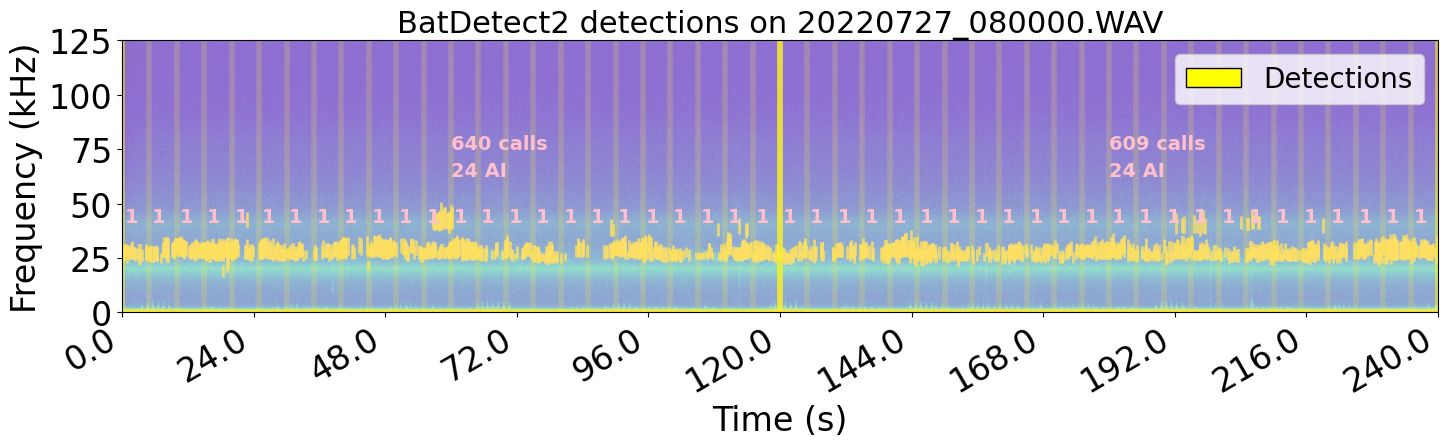

In [14]:
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)

In [15]:
data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['cur_dc_tag'] = '1of2'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['metric_tag'] = 'bout_time_percentage'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
file_paths = get_file_paths(data_params)

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), data_params['cycle_length'], data_params['time_on_in_secs'], data_params)

In [16]:
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=dt.datetime(2022,7,27,8,0,0))&(dc_applied_df['call_end_time']<=dt.datetime(2022,7,27,8,30,0))]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

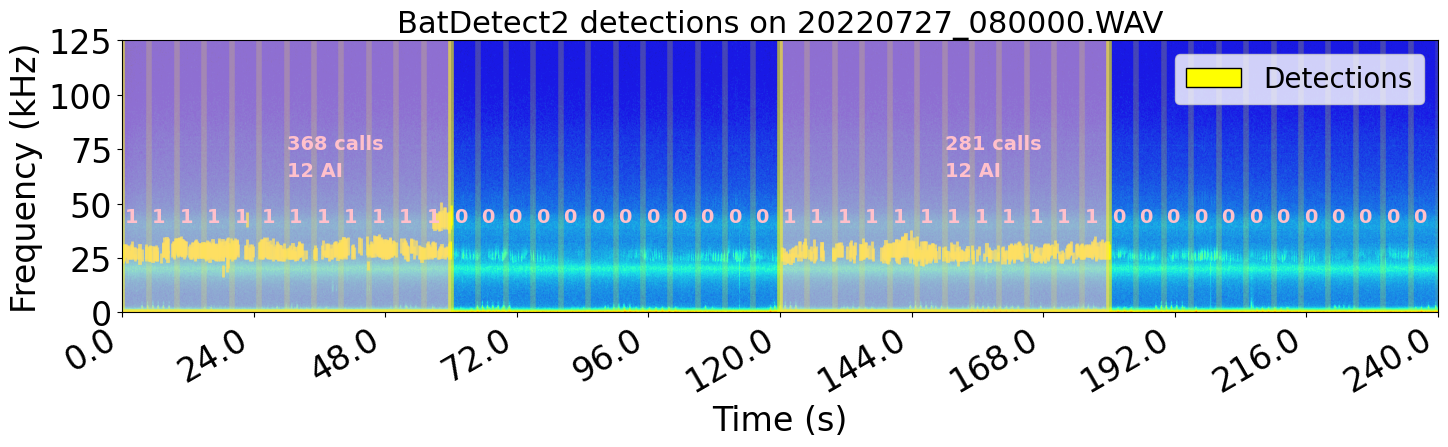

In [17]:
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)